In [4]:
import os
import numpy as np
import glob
import random
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import defaultdict

class SkinLesionLoader(Dataset):
    def __init__(self, transform, dataset_path, split='train'):
        'Initialization'
        self.transform = transform  # This transformation is for the input image only.
        
        # Collect all image paths and label paths
        self.image_paths = []
        self.label_paths = []

        # Loop through all IMG### folders
        for folder_name in os.listdir(dataset_path):
            folder_path = os.path.join(dataset_path, folder_name)
            if os.path.isdir(folder_path):
                # Add dermoscopic image path
                dermoscopic_image_path = os.path.join(folder_path, f'{folder_name}_Dermoscopic_Image', f'{folder_name}.bmp')
                if os.path.exists(dermoscopic_image_path):
                    self.image_paths.append(dermoscopic_image_path)
                
                # Add lesion image path
                lesion_image_path = os.path.join(folder_path, f'{folder_name}_lesion', f'{folder_name}_lesion.bmp')
                if os.path.exists(lesion_image_path):
                    self.label_paths.append(lesion_image_path)

        # Ensure both lists have the same length
        assert len(self.image_paths) == len(self.label_paths), "Image and label counts do not match."

        # Randomly shuffle the dataset
        combined = list(zip(self.image_paths, self.label_paths))
        random.shuffle(combined)
        self.image_paths, self.label_paths = zip(*combined)

        # Split indices for 70-15-15
        total_len = len(self.image_paths)
        train_split = int(total_len * 0.7)
        val_split = int(total_len * 0.85)  # 70% for training, next 15% for validation

        if split == 'train':
            self.image_paths = self.image_paths[:train_split]
            self.label_paths = self.label_paths[:train_split]
        elif split == 'val':
            self.image_paths = self.image_paths[train_split:val_split]
            self.label_paths = self.label_paths[train_split:val_split]
        elif split == 'test':
            self.image_paths = self.image_paths[val_split:]
            self.label_paths = self.label_paths[val_split:]
        else:
            raise ValueError("Invalid split name. Use 'train', 'val', or 'test'.")

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        
        image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB format
        label = Image.open(label_path).convert("L")    # Ensure label is in grayscale
        
        # Apply transform only to the image
        X = self.transform(image)
        
        # Convert label to a numpy array (keep original size)
        Y = np.array(label)
        
        # Generate weak annotations (positive and negative clicks)
        pos_points, neg_points = self.generate_click_points(Y)
        
        return X, Y, pos_points, neg_points

    def generate_click_points(self, label_np, alpha=2, beta=5):
        # Get positive and negative pixels
        positive_pixels = np.argwhere(label_np > 0)  # Lesion region
        negative_pixels = np.argwhere(label_np == 0) # Background region
        
        # Positive Clicks - sample points based on a Beta distribution
        num_points = 20
        lesion_area = positive_pixels.shape[0]
        
        # Use Beta distribution to spread points across the lesion
        positive_points = []
        for _ in range(num_points):
            # Sample a point index using a Beta distribution, scale it to the range of lesion area
            index = int(np.round(np.random.beta(alpha, beta) * (lesion_area - 1)))
            index = np.clip(index, 0, lesion_area - 1)  # Ensure index is within bounds
            positive_points.append(positive_pixels[index])
        positive_points = np.array(positive_points)

        # Negative Clicks - ensure minimum distance from lesion boundary
        min_distance = 15
        negative_points = []
        for _ in range(num_points):
            neg_point = random.choice(negative_pixels)
            while np.min(np.linalg.norm(positive_pixels - neg_point, axis=1)) < min_distance:
                neg_point = random.choice(negative_pixels)
            negative_points.append(neg_point)
        negative_points = np.array(negative_points)
        
        return positive_points, negative_points

# Usage
data_path = "/dtu/datasets1/02516/PH2_Dataset_images"
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a fixed size
    transforms.ToTensor()             # Convert to tensor
])

# Create dataset instances for train, validation, and test
train_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='train')
val_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='val')
test_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='test')

# Optional: Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

def evaluate_sampling_strategy(dataset, alpha_values, beta_values, n_samples=5):
    results = defaultdict(list)
    
    for alpha in alpha_values:
        for beta in beta_values:
            iou_scores = []
            for _ in range(n_samples):
                sampled_indices = random.sample(range(len(dataset)), 1)
                for idx in sampled_indices:
                    _, label, pos_points, _ = dataset[idx]
                    dataset.generate_click_points(label, alpha=alpha, beta=beta)
                    # Assume IoU calculation here for simplicity
                    iou_score = np.random.random()  # Placeholder for an actual IoU computation
                    iou_scores.append(iou_score)
            avg_iou = np.mean(iou_scores)
            results[(alpha, beta)] = avg_iou
            print(f"Alpha: {alpha}, Beta: {beta}, Avg IoU: {avg_iou:.3f}")
    return results

# Define the range of alpha and beta values to try
alpha_values = [1, 2, 3, 4, 5]
beta_values = [1, 2, 3, 4, 5]

# Evaluate and plot results
results = evaluate_sampling_strategy(train_dataset, alpha_values, beta_values)

# Plotting the results
alphas_betas = list(results.keys())
ious = list(results.values())

fig, ax = plt.subplots(figsize=(10, 6))
for (alpha, beta), iou in zip(alphas_betas, ious):
    ax.scatter(alpha, beta, s=100, c=iou, cmap='viridis', alpha=0.6)
ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.set_title('Average IoU for Different Alpha and Beta Values')
plt.colorbar(ax.scatter(alpha, beta, s=100, c=iou, cmap='viridis', alpha=0.6), label='Average IoU')
plt.show()

def display_mask_with_annotations(dataset, n_samples=5):
    sampled_indices = random.sample(range(len(dataset)), min(n_samples, len(dataset)))
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sampled_indices):
        # Get image, label, and points
        image, label, pos_points, neg_points = dataset[idx]

        # The label is already in NumPy format, no need to convert
        # Plot segmentation mask with positive and negative points overlaid
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(label, cmap='gray')
        plt.scatter(pos_points[:, 1], pos_points[:, 0], c='green', label='Positive Clicks', marker='o', s=10)  # Plot positive points
        plt.scatter(neg_points[:, 1], neg_points[:, 0], c='red', label='Negative Clicks', marker='x', s=10)  # Plot negative points
        plt.title("Segmentation Mask with Annotations")
        plt.axis("off")

    # Adding a legend for the entire figure (only once)
    plt.figlegend(loc='upper center', ncol=2)
    plt.tight_layout()
    plt.show()

# Display masks with positive and negative points from the training dataset
display_mask_with_annotations(train_dataset, n_samples=5)


Alpha: 1, Beta: 1, Avg IoU: 0.561
Alpha: 1, Beta: 2, Avg IoU: 0.371
Alpha: 1, Beta: 3, Avg IoU: 0.490
Alpha: 1, Beta: 4, Avg IoU: 0.616
Alpha: 1, Beta: 5, Avg IoU: 0.343


KeyboardInterrupt: 

### BEST ALFA and BETA

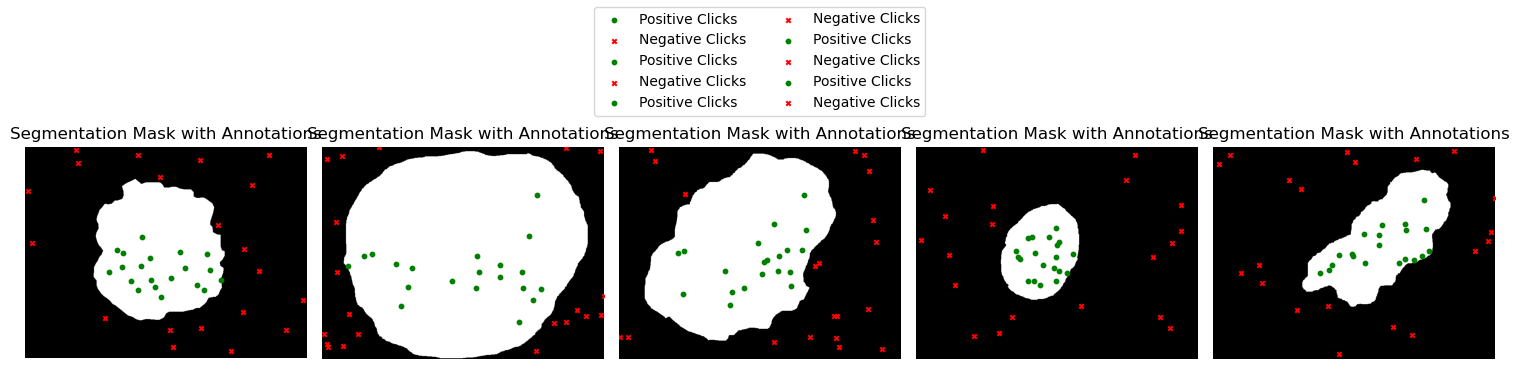

In [5]:
import os
import numpy as np
import glob
import random
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class SkinLesionLoader(Dataset):
    def __init__(self, transform, dataset_path, split='train'):
        'Initialization'
        self.transform = transform  # This transformation is for the input image only.
        
        # Collect all image paths and label paths
        self.image_paths = []
        self.label_paths = []

        # Loop through all IMG### folders
        for folder_name in os.listdir(dataset_path):
            folder_path = os.path.join(dataset_path, folder_name)
            if os.path.isdir(folder_path):
                # Add dermoscopic image path
                dermoscopic_image_path = os.path.join(folder_path, f'{folder_name}_Dermoscopic_Image', f'{folder_name}.bmp')
                if os.path.exists(dermoscopic_image_path):
                    self.image_paths.append(dermoscopic_image_path)
                
                # Add lesion image path
                lesion_image_path = os.path.join(folder_path, f'{folder_name}_lesion', f'{folder_name}_lesion.bmp')
                if os.path.exists(lesion_image_path):
                    self.label_paths.append(lesion_image_path)

        # Ensure both lists have the same length
        assert len(self.image_paths) == len(self.label_paths), "Image and label counts do not match."

        # Randomly shuffle the dataset
        combined = list(zip(self.image_paths, self.label_paths))
        random.shuffle(combined)
        self.image_paths, self.label_paths = zip(*combined)

        # Split indices for 70-15-15
        total_len = len(self.image_paths)
        train_split = int(total_len * 0.7)
        val_split = int(total_len * 0.85)  # 70% for training, next 15% for validation

        if split == 'train':
            self.image_paths = self.image_paths[:train_split]
            self.label_paths = self.label_paths[:train_split]
        elif split == 'val':
            self.image_paths = self.image_paths[train_split:val_split]
            self.label_paths = self.label_paths[train_split:val_split]
        elif split == 'test':
            self.image_paths = self.image_paths[val_split:]
            self.label_paths = self.label_paths[val_split:]
        else:
            raise ValueError("Invalid split name. Use 'train', 'val', or 'test'.")

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        
        image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB format
        label = Image.open(label_path).convert("L")    # Ensure label is in grayscale
        
        # Apply transform only to the image
        X = self.transform(image)
        
        # Convert label to a numpy array (keep original size)
        Y = np.array(label)
        
        # Generate weak annotations (positive and negative clicks)
        pos_points, neg_points = self.generate_click_points(Y)
        
        return X, Y, pos_points, neg_points

    def generate_click_points(self, label_np):
        # Get positive and negative pixels
        positive_pixels = np.argwhere(label_np > 0)  # Lesion region
        negative_pixels = np.argwhere(label_np == 0) # Background region
        
        # Positive Clicks - sample points based on a Beta distribution
        num_points = 20
        lesion_area = positive_pixels.shape[0]
        
        # Use Beta distribution to spread points across the lesion
        alpha, beta = 4, 3  # Adjust alpha and beta for desired spread
        positive_points = []
        for _ in range(num_points):
            # Sample a point index using a Beta distribution, scale it to the range of lesion area
            index = int(np.round(np.random.beta(alpha, beta) * (lesion_area - 1)))
            index = np.clip(index, 0, lesion_area - 1)  # Ensure index is within bounds
            positive_points.append(positive_pixels[index])
        positive_points = np.array(positive_points)

        # Negative Clicks - ensure minimum distance from lesion boundary
        min_distance = 15
        negative_points = []
        for _ in range(num_points):
            neg_point = random.choice(negative_pixels)
            while np.min(np.linalg.norm(positive_pixels - neg_point, axis=1)) < min_distance:
                neg_point = random.choice(negative_pixels)
            negative_points.append(neg_point)
        negative_points = np.array(negative_points)
        
        return positive_points, negative_points

# Usage
data_path = "/dtu/datasets1/02516/PH2_Dataset_images"
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a fixed size
    transforms.ToTensor()             # Convert to tensor
])

# Create dataset instances for train, validation, and test
train_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='train')
val_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='val')
test_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='test')

# Optional: Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

def display_mask_with_annotations(dataset, n_samples=5):
    sampled_indices = random.sample(range(len(dataset)), min(n_samples, len(dataset)))
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sampled_indices):
        # Get image, label, and points
        image, label, pos_points, neg_points = dataset[idx]

        # The label is already in NumPy format, no need to convert
        # Plot segmentation mask with positive and negative points overlaid
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(label, cmap='gray')
        plt.scatter(pos_points[:, 1], pos_points[:, 0], c='green', label='Positive Clicks', marker='o', s=10)  # Plot positive points
        plt.scatter(neg_points[:, 1], neg_points[:, 0], c='red', label='Negative Clicks', marker='x', s=10)  # Plot negative points
        plt.title("Segmentation Mask with Annotations")
        plt.axis("off")

    # Adding a legend for the entire figure (only once)
    plt.figlegend(loc='upper center', ncol=2)
    plt.tight_layout()
    plt.show()

# Display masks with positive and negative points from the training dataset
display_mask_with_annotations(train_dataset, n_samples=5)
